## 2. 使用nano-gpt2.0模型，训练一份中文语料并测试生成。


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F


def get_batch(split):
    # 选择数据集或者验证集
    data = train_data if split == 'train' else val_data

    ix = torch.randint(len(train_data) - block_size, (batch_size, ) ) #【0， 103846】随机生成位置索引，向后截取block_size字符巡检
    x = torch.stack([train_data[i:i+block_size] for i in ix])
    y = torch.stack([train_data[i+1:i+block_size+1] for i in ix])
    return x, y
    
class Head(nn.Module):
    # 单头 self-attention
    def __init__(self, n_emb):
        super().__init__()
        self.key = nn.Linear(n_emb,n_emb, bias=False)
        self.query = nn.Linear(n_emb,n_emb, bias=False)
        self.value = nn.Linear(n_emb,n_emb, bias=False)

    def forward(self, input_x):
        B, T, C = input_x.shape

        k = self.key(input_x)
        q = self.query(input_x)
        v = self.value(input_x)

        wei = q @ k.transpose(-2, -1) * C ** -0.5

        T = wei.shape[-1]
        tril = torch.tril(torch.ones(T, T))
        wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei,dim=-1)

        out = wei @ v
        return out


class BingramLanguageModel(nn.Module):
 
    def __init__(self, block_size, vocab_size, n_embd):
        super().__init__()
        # 每个token都直接从Embedding中查询对应的logits值 以进⾏下⼀个token的推理
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # 添加位置编码
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # one head self-attention
        self.sa_head = Head(n_embd)

        # larg model forward
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size  # 保存 block_size


        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        T = min(T, self.block_size)
        idx = idx[:, -T:]  # 取最后 T 个元素


        # idx值和target值都是整型张量
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T))

        x = tok_emb + pos_emb
        x = self.sa_head(x)
        logits = self.lm_head(x)
 
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx (B,T) 数组对应着当前的输⼊内容 [1,1]
        for _ in range(max_new_tokens):
            # 模型推理
            logits, loss = self(idx) # (B,T) -> (1,1...100)
            # 获取最后⼀个时间步的输出
            logits = logits[:, -1, :] # (1,100,65) -> (1,65)
            # 应⽤softmax转换为概率值
            probs = F.softmax(logits, dim=-1) # (B,C)
            # 按权重值采样，返回对应的索引
            # idx_next = torch.argmax(probs, dim=-1)
            # 随机采样
            idx_next = torch.multinomial(probs,num_samples=1) # (B,1)
            # 应⽤采样后的索引
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) [1,2],[1,3]... [1,max_new_tokens]
        return idx

if __name__ == '__main__':
    # 训练文本采样长度（演示）
    # 模型的训练数据集
    block_size = 8
    batch_size = 32
    max_iter = 10000
    learn_rate = 1e-1
    n_embd = 32
    eval_interval = 500
    eval_iters = 200

    

    # with open('/Users/peiqi/code/AiPremiumClass/李思佳/week16/199801.txt','r') as f:
    #     text = f.read()

        # 尝试不同的编码读取文件
    try:
        with open('/Users/peiqi/code/AiPremiumClass/李思佳/week16/199801.txt', 'r', encoding='utf-8') as f:
            text = f.read()
    except UnicodeDecodeError:
        try:
            with open('/Users/peiqi/code/AiPremiumClass/李思佳/week16/199801.txt', 'r', encoding='gbk') as f:
                text = f.read()
        except UnicodeDecodeError:
            try:
                with open('/Users/peiqi/code/AiPremiumClass/李思佳/week16/199801.txt', 'r', encoding='gb2312') as f:
                    text = f.read()
            except UnicodeDecodeError:
                # 使用 'ignore' 参数忽略解码错误
                with open('/Users/peiqi/code/AiPremiumClass/李思佳/week16/199801.txt', 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()


    # 词典、编码器(函数)、解码器（函数）
    chars = sorted(list(set(text)))
    vacob_size = len(chars)
    stoi = {ch:i for i, ch in enumerate(chars)}
    itos = {i:ch for i, ch in enumerate(chars)}

    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])

    data = torch.tensor(encode(text), dtype=torch.long)


    # 拆分数据集
    n = int(len(data) * 0.9)
    train_data = data[:n]
    val_data = data[n:]


    x = train_data[:block_size]
    y = train_data[1:block_size+1]
    print(x)
    print(y)
    for t in range(block_size):
        context = x[:t+1]
        target = y[t]
        print(f'输入内容：{context}, 预测的目标：{target}')



    model = BingramLanguageModel(block_size, vacob_size, n_embd)
    # 模型训练
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate)
    def estimate_loss():
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out
    
    for iter in range(max_iter):
        if iter % eval_interval == 0:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # 批次样本
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # 模型生成
    print(decode(model.generate(torch.zeros((1,1), dtype=torch.long), 500)[0].tolist()))

tensor([ 5, 13, 13, 12,  4,  5,  4,  5])
tensor([13, 13, 12,  4,  5,  4,  5,  2])
输入内容：tensor([5]), 预测的目标：13
输入内容：tensor([ 5, 13]), 预测的目标：13
输入内容：tensor([ 5, 13, 13]), 预测的目标：12
输入内容：tensor([ 5, 13, 13, 12]), 预测的目标：4
输入内容：tensor([ 5, 13, 13, 12,  4]), 预测的目标：5
输入内容：tensor([ 5, 13, 13, 12,  4,  5]), 预测的目标：4
输入内容：tensor([ 5, 13, 13, 12,  4,  5,  4]), 预测的目标：5
输入内容：tensor([ 5, 13, 13, 12,  4,  5,  4,  5]), 预测的目标：2
step 0: train loss 8.4638, val loss 8.4630
step 500: train loss 61.2309, val loss 61.6074
step 1000: train loss 3.6924, val loss 3.7136
step 1500: train loss 3.5317, val loss 3.5175
step 2000: train loss 3.4221, val loss 3.4103
step 2500: train loss 3.1729, val loss 3.1439
step 3000: train loss 2.6916, val loss 2.6954
step 3500: train loss 3.4867, val loss 3.5438
step 4000: train loss 249.4939, val loss 243.6166
step 4500: train loss 11.0956, val loss 11.1036
step 5000: train loss 3.6688, val loss 3.6577
step 5500: train loss 3.5488, val loss 3.5630
step 6000: train loss 3.5249, va

#### 运行截图


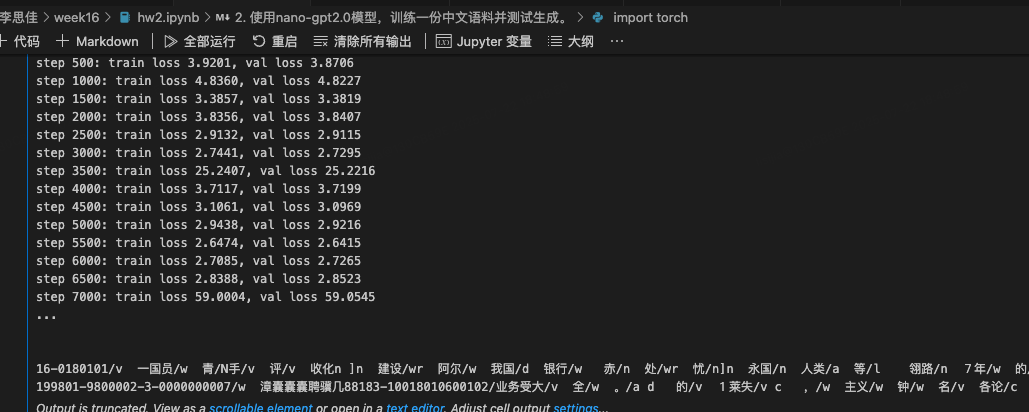